In [2]:
# Import packages
import h5py
import numpy as np

import sigpy as sp
from sigpy import backend, linop, prox, util
from sigpy.alg import (PowerMethod, GradientMethod,
                       ConjugateGradient, PrimalDualHybridGradient)
import sigpy.plot as pl
import matplotlib.pyplot as plt
import sys
import os

%matplotlib inline
#where to find the file cfl.py
cflpath = "../bart/python"
sys.path.append(os.path.abspath(cflpath))
import cfl

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
#read dataset: brain dataset
h5_dataset_brain = h5py.File('rawdata_brain_radial_96proj_12ch.h5', 'r')

h5_dataset_rawdata_name = list(h5_dataset_brain.keys())[0]
h5_dataset_trajectory_name = list(h5_dataset_brain.keys())[1]

trajectory = h5_dataset_brain.get(h5_dataset_trajectory_name).value
rawdata = h5_dataset_brain.get(h5_dataset_rawdata_name).value

gpu_number = -1

coor = trajectory[:2,:,:].transpose((1,2,0))
coor = sp.backend.to_device(coor,gpu_number)
rawdata_brain = rawdata[0,:,:,:].transpose((2,0,1))
rawdata_brain = sp.backend.to_device(rawdata_brain,gpu_number)

In [4]:
#generating coil sensitivity profiles
image = cfl.readcfl("img_igrid_brain")
image_sos = sp.util.rss(image,3)
sens_maps = image[:,:,0,:]/image_sos
sens_maps_t = sens_maps.transpose((2,0,1))
sens_maps_t = sp.backend.to_device(sens_maps_t,gpu_number)

In [5]:
#Building the SENSE operator using nuFFT
S = sp.linop.Multiply((1,300,300),sens_maps_t)
NUFFT = sp.linop.NUFFT((12,300,300),coor)
E = NUFFT*S

In [36]:
# Build a sigpy app that takes a referenz image and computes difference in each iteration
class LinearLeastSquares_ref(sp.app.LinearLeastSquares):
    def __init__(self, A, y, x=None, proxg=None,
                 lamda=0, G=None, g=None, R=None, mu=0, z=0,
                 alg_name=None, max_iter=100,
                 P=None, alpha=None, max_power_iter=30, accelerate=True,
                 tau=None, sigma=None,
                 save_objective_values=True, show_pbar=True, reference_image=None, save_res=True):
        self.A = A
        self.y = y
        self.x = x
        self.proxg = proxg
        self.lamda = lamda
        self.G = G
        self.g = g
        self.R = R
        self.mu = mu
        self.z = z
        self.alg_name = alg_name
        self.max_iter = max_iter
        self.P = P
        self.alpha = alpha
        self.max_power_iter = max_power_iter
        self.accelerate = accelerate
        self.tau = tau
        self.sigma = sigma
        self.save_objective_values = save_objective_values
        self.show_pbar = show_pbar
        self.reference_image = reference_image
        self.save_res = save_res
        
        self.y_device = backend.get_device(y)
        if self.x is None:
            with self.y_device:
                self.x = self.y_device.xp.zeros(A.ishape, dtype=y.dtype)

        self.x_device = backend.get_device(self.x)
        self._get_alg()
        
        if self.save_objective_values:
            self.objective_values = []
        
        if self.save_res:
            self.res = [] # residual
            
        if self.reference_image is not None:
            self.diff_to_reference = []

    def get_diff_to_reference(self):
        with self.y_device:
            r = self.x - self.reference_image
            diff = self.y_device.xp.linalg.norm(r)
        return util.asscalar(diff)
            
    def _summarize(self):
        if self.save_objective_values:
            self.objective_values.append(self.objective())
        
        if self.save_res:
            self.res.append(self.alg.resid)
            
        if self.reference_image is not None:
            self.diff_to_reference.append(self.get_diff_to_reference())
            
        if self.show_pbar:
            if self.save_objective_values:
                self.pbar.set_postfix(
                    obj='{0:.2E}'.format(self.objective_values[-1]))
            else:
                self.pbar.set_postfix(resid='{0:.2E}'.format(self.alg.resid))            
            
    def _post_update(self):

        return
        



In [42]:
# Modify conjugate gradient algorithm to output a different residual
class ConjugateGradient_rrsg(sp.alg.Alg):
    r"""Conjugate Gradient Method. Solves for:

    .. math:: A x = b

    where A is hermitian.

    Args:
        A (Linop or function): Linop or function to compute A.
        b (array): Observation.
        x (array): Variable.
        P (function or None): Preconditioner.
        max_iter (int): Maximum number of iterations.
        tol (float): Tolerance for stopping condition.

    """

    def __init__(self, A, b, x, P=None, max_iter=100, tol=0):
        self.A = A
        self.P = P
        self.x = x
        self.tol = tol
        self.device = backend.get_device(x)
        with self.device:
            xp = self.device.xp
            self.r = A.H*b - self.A.H(self.A(self.x))

            if self.P is None:
                z = self.r
            else:
                z = self.P(self.r)

            if max_iter > 1:
                self.p = z.copy()
            else:
                self.p = z

            self.not_positive_definite = False
            self.rzold = xp.real(xp.vdot(self.r, z))
            
            self.resid = util.norm2(self.r)/util.norm2(self.A.H(b))
        super().__init__(max_iter)


    def _update(self):
        with self.device:
            xp = self.device.xp
            Ap = self.A(self.p)
            pAp = xp.real(xp.vdot(self.p, Ap)).item()
            if pAp <= 0:
                self.not_positive_definite = True
                return

            self.alpha = self.rzold / pAp
            util.axpy(self.x, self.alpha, self.p)
            if self.iter < self.max_iter - 1:
                util.axpy(self.r, -self.alpha, Ap)
                if self.P is not None:
                    z = self.P(self.r)
                else:
                    z = self.r

                rznew = xp.real(xp.vdot(self.r, z))
                beta = rznew / self.rzold
                util.xpay(self.p, beta, z)
                self.rzold = rznew
                
#             self.resid = util.norm2(self.r)/util.norm2(b)
            self.resid = util.norm2(self.r)/util.norm2(self.A.H(b))

    def _done(self):
        return (self.iter >= self.max_iter or
                self.not_positive_definite or self.resid <= self.tol)


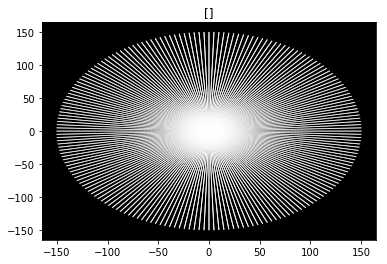

A input shape = [1, 300, 300]
A output shape = [12, 512, 96]


In [99]:
# Define density compensation

def get_dcf(coor):
    pl.ScatterPlot(coor)
    kmax = np.amax(coor)
    coord_shape = coor.shape
    nro, ntr, ndim = coord_shape
    dcf = np.zeros((nro,ntr))
    delta_k = kmax/nro
    for i in range(nro):
        for j in range(ntr):
            if (i == 0) or (j == 0):
                dcf[i,j] = 2*np.pi * 1/ntr * delta_k**2 * 1/8
            else:
                dcf[i,j] = 2*np.pi * 1/ntr * delta_k**2 * j
    return dcf


# Intensity correction
img_shape = (1,300,300)
intensity = sp.util.rss(sens_maps_t)
I = sp.linop.Multiply(img_shape,intensity)

# Compose linear operators
S = sp.linop.Multiply(img_shape,sens_maps_t)
NUFFT = sp.linop.NUFFT(S.oshape,coor)
E = NUFFT*S*I
dcf = get_dcf(coor)
D = sp.linop.Multiply(E.oshape,dcf)
A = D*E
print("A input shape = {}".format(A.ishape))
print("A output shape = {}".format(A.oshape))

In [100]:
s = LinearLeastSquares_ref(A,rawdata_brain,max_iter=10)
img_rec_iter10 = s.run()
img_rec_iter10_gpu = sp.backend.to_device(img_rec_iter10,gpu_number)
s = LinearLeastSquares_ref(Operator,rawdata_brain,max_iter=100,reference_image=img_rec_iter10_gpu)
img_rec_now = s.run()


LinearLeastSquares_ref: 100%|██████████| 10/10 [00:02<00:00,  3.39it/s, obj=2.26E-03]

LinearLeastSquares_ref:  20%|██        | 20/100 [00:05<00:23,  3.44it/s, obj=5.64E-04]


LinearLeastSquares_ref:  50%|█████     | 50/100 [00:15<00:14,  3.35it/s, obj=5.63E-04]


LinearLeastSquares_ref:  81%|████████  | 81/100 [00:24<00:05,  3.39it/s, obj=5.63E-04]


LinearLeastSquares_ref: 100%|██████████| 100/100 [00:30<00:00,  3.23it/s, obj=5.63E-04]


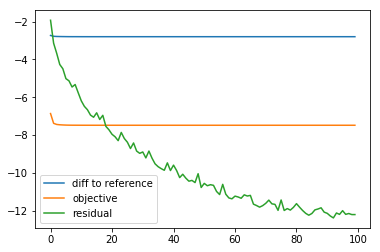

In [101]:
plt.plot(np.log(s.diff_to_reference),label='diff to reference')
plt.plot(np.log(s.objective_values),label='objective')
plt.plot(np.log(s.res),label="residual")
plt.legend()
plt.show()

(300, 300)


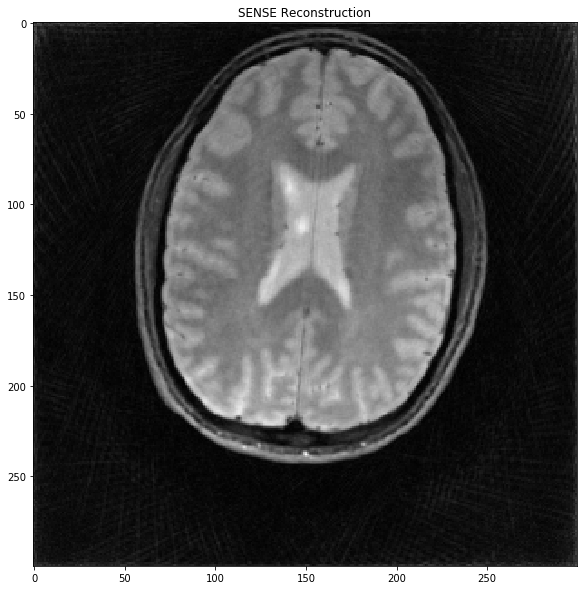

In [102]:
img_rec_now = sp.backend.to_device(img_rec_now)
im_abs_recon_now = abs(img_rec_now[0,:,:])
print(im_abs_recon_now.shape)
plt.figure(figsize=(20,10))
plt.title("SENSE Reconstruction")
plt.imshow(im_abs_recon_now[::-1,:],cmap='gray')
plt.show()